In [1]:
import json
import os
import re
from types import SimpleNamespace

import torch
import torch.nn.functional as F
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

from matplotlib.colors import LogNorm
from model.util import FISTA_pytorch

from utils.data_loader import load_celeba
from model.feature_enc import ConvDecoder
from model.vi_encoder import VIEncoder

In [2]:
pearson = False
kl = "kl1e-4"
samp = 5
z = 64
p_sparsity = 10

file_list = [
    f"results_celeba/{kl}/gaussian_{kl}_{samp}samp_z{z}/",
    f"results_celeba/{kl}/{p_sparsity}/spikeslab_{kl}_{samp}samp_z{z}/",
    f"results_celeba/{kl}/{p_sparsity}/gaussian_thresh_{kl}_{samp}samp_z{z}/",
    #f"results_celeba/{kl}/laplacian_thresh_{kl}_{samp}samp_z{z}/",
    f"results_celeba/{kl}/{p_sparsity}/gaussian_learnthresh_{kl}_{samp}samp_z{z}/",

]

file_labels = [
    "Gaussian",
    "Spike-and-Slab",
    "Thresh Gaussian",
    #"Thresh Laplacian",
    "Thresh Gaussian+Gamma",
]

attribute_labels = {
    "5 O'Clock Shadow": False,
    "Arched Eyebrows": False,
    "Attractive": False,
    "Bags Under Eyes": False,
    "Bald": True,
    "Bangs": True,
    "Big Lips": False,
    "Big Noise": False,
    "Black Hair": True,
    "Blonde Hair": True,
    "Blurry": False,
    "Brown Hair": False,
    "Bushy Eyebrows": False,
    "Chubby": False,
    "Double Chin": False,
    "Eyeglasses": True,
    "Goatee": False,
    "Gray Hair": False,
    "Heavy Makeup": False,
    "High Cheekbones": False,
    "Male": True,
    "Mouth Slightly Open": False,
    "Mustache": False,
    "Narrow Eyes": False,
    "No Beard": False,
    "Oval Face": False,
    "Pale Skin": True,
    "Pointy Nose": False,
    "Receding Hairline": False,
    "Rosy Cheeks": False,
    "Sideburns": False,
    "Smiling": True,
    "Straight Hair": False,
    "Wavy Hair": False,
    "Wearing Earrings": False,
    "Wearing Hat": False,
    "Wearing Lipstick": False,
    "Wearing Necklace": False,
    "Wearing Necktie": False,
    "Young": False
}   

In [3]:
default_device = torch.device('cuda:0')
with open(file_list[0] + 'config.json') as json_data:
    config_data = json.load(json_data)
#logging.basicConfig(filename=f"figures/vsc_grad_stats/vscgrad_{file_suffix}.txt", 
#                    filemode='w', level=logging.DEBUG)
train_args = SimpleNamespace(**config_data['train'])
train_args.batch_size = 50
_, test_loader = load_celeba("./data/", train_args)

x_samp_dict = {}

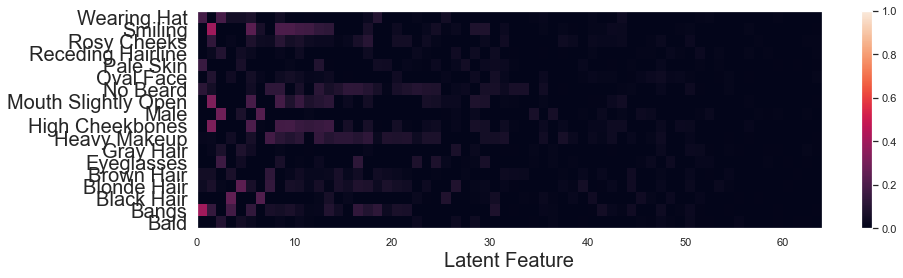

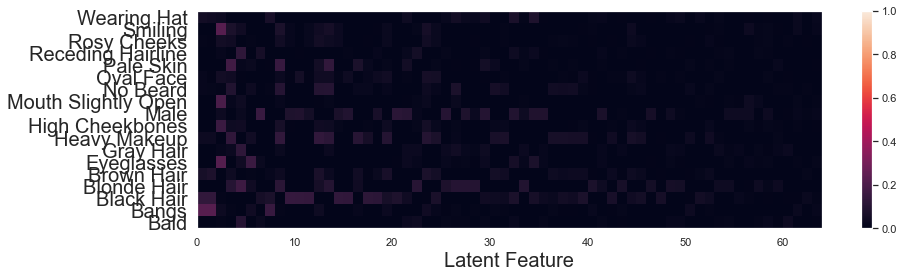

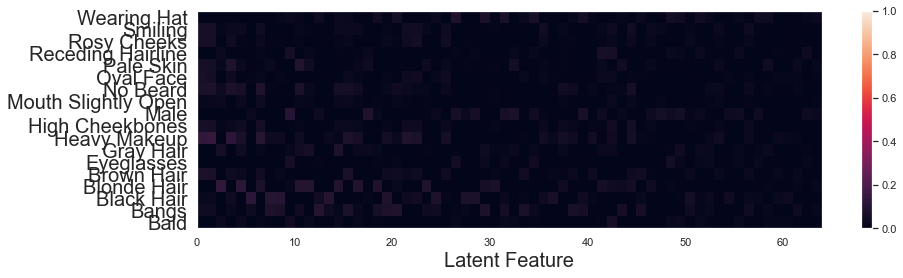

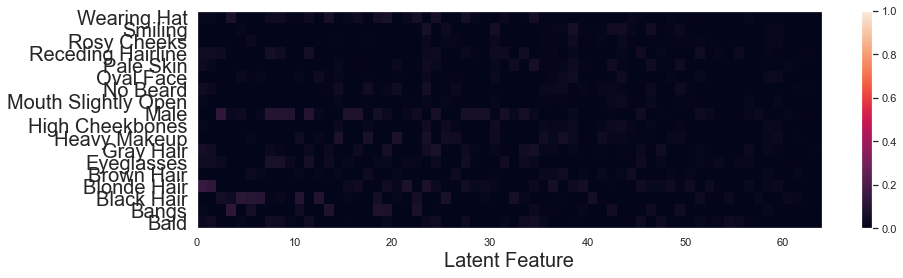

In [4]:
correlation_dict = {}

for file_idx, train_run in enumerate(file_list):
    with open(train_run + 'config.json') as json_data:
        config_data = json.load(json_data)
    train_args = SimpleNamespace(**config_data['train'])
    solver_args = SimpleNamespace(**config_data['solver'])

    correlation_dict[train_run] = np.zeros((train_args.dict_size, 40))

    train_args.batch_size = 50
    solver_args.sample_method = "max"
    solver_args.num_samples = 50

    epoch_list = [int(re.search(r'epoch([0-9].*).pt', f)[1]) for f in os.listdir(train_run) if re.search(r'epoch([0-9].*).pt', f)]
    epoch_list = np.sort(epoch_list)
    epoch_list = [epoch_list[-1]]

    x_samp_dict[file_labels[file_idx]] = []

    for epoch in epoch_list:
        np.random.seed(train_args.seed)
        torch.manual_seed(train_args.seed)

        model_state = torch.load(train_run + f"modelstate_epoch{epoch}.pt", map_location=default_device)
        decoder = ConvDecoder(train_args.dict_size, 3).to(default_device)
        decoder.load_state_dict(model_state['decoder'])
        if solver_args.solver == "VI":
            encoder = VIEncoder(16, train_args.dict_size, solver_args).to(default_device)  
            encoder.load_state_dict(model_state['encoder'])
            encoder.ramp_hyperparams()
            encoder.eval()
        decoder.eval()

        y_samp = torch.zeros(len(test_loader.dataset), len(attribute_labels))
        x_samp = torch.zeros((len(test_loader.dataset), train_args.dict_size))
        for idx, (x, y) in enumerate(test_loader):
            x, y = x.to(default_device), y.to(default_device)
            y_samp[idx*train_args.batch_size:(idx+1)*train_args.batch_size] = y.detach().cpu()

            if solver_args.solver == "FISTA":
                for j in range(5):
                    (recon_loss, _, _), b_trial = FISTA_pytorch(x, decoder, train_args.dict_size, 
                                            solver_args.lambda_, max_iter=1500, tol=1e-6, 
                                            clip_grad=solver_args.clip_grad, device=default_device)
                    if j == 0:
                        min_recon = recon_loss.mean(dim=(1,2,3))
                        b_cu = b_trial
                    elif (min_recon > recon_loss.mean(dim=(1,2,3))).any():
                        update_idx = (min_recon > recon_loss.mean(dim=(1,2,3)))
                        b_cu[update_idx] = b_trial[update_idx]
            else:
                with torch.no_grad():
                    iwae_loss, recon_loss, kl_loss, b_cu, weight = encoder(x, decoder)
                    sample_idx = torch.distributions.categorical.Categorical(weight).sample().detach()
                    b_cu = b_cu[torch.arange(len(b_cu)), sample_idx]
            x_samp[idx*train_args.batch_size:(idx+1)*train_args.batch_size] = b_cu.detach().cpu()
                    
            """
            for k in range(len(x)):
                y1_idx = torch.nonzero(y[k] == 0)
                y0_idx = torch.nonzero(y[k])
                p_xy1[y1_idx] += spike[k] / len(test_loader.dataset)
                p_xy0[y0_idx] += spike[k] / len(test_loader.dataset)
            """

        x_samp_dict[file_labels[file_idx]].append(x_samp)
        #attribute_idx = [4, 5, 8, 9, 11, 15, 20, 21, 24, 26, 28, 31, 35]
        #attribute_idx = [4, 8, 9, 11, 15, 24, 26, 28, 31, 35]
        label_list = np.array(list(attribute_labels.keys()))
        attribute_idx = [i for i in range(len(label_list)) if attribute_labels[label_list[i]]]      

        if pearson:
            x_mean = x_samp.mean(dim=0)[None, :, None]
            y_mean = x_samp.mean(dim=0)[None, None]

            x_centered = (x_samp - x_samp.mean(dim=0)[None])
            y_centered = (y_samp - y_samp.mean(dim=0)[None])
            x_std = x_samp.std(dim=0)
            y_std = y_samp.std(dim=0)
            r = (1 / (len(x_samp) - 1)) * ((x_centered / x_std)[:, None] * (y_centered / y_std)[:, :, None]).sum(dim=0).abs()
            feat_ord = (-1 * r.max(dim=0)[0]).argsort()

            plt.figure(figsize=(18,5))
            #plt.imshow(r[attribute_idx][:, feat_ord], interpolation='none')
            plt.pcolormesh(r[attribute_idx][:, feat_ord], vmin=0., vmax=1.)
            plt.yticks(np.arange(len(attribute_idx)) + 0.5, np.array(attribute_labels)[attribute_idx])
            plt.xlabel("Latent Feature")
            plt.title(f"{file_labels[file_idx]} Pearson Correlation")
            plt.colorbar()
        else:
            r = torch.zeros((40, train_args.dict_size))
            x_std = x_samp.std(dim=0, unbiased=False)

            for j in range(len(r)):

                y0 = torch.nonzero(y_samp[:, j])
                y1 = torch.nonzero(y_samp[:, j] == 0)

                x0_mean = x_samp[y0].mean(dim=0)
                x1_mean = x_samp[y1].mean(dim=0)

                r[j] = (x1_mean - x0_mean) / x_std
                r[j] *= np.sqrt((len(y0) * len(y1)) / len(y_samp)**2)
                
            correlation_dict[train_run] = r.T.detach().cpu().numpy()
            feat_ord = (-1 * r.max(dim=0)[0]).argsort()
            plt.figure(figsize=(14,4))
            #plt.imshow(r[attribute_idx][:, feat_ord], interpolation='none')
            plt.pcolormesh(r[attribute_idx][:, feat_ord], vmin=0., vmax=1.)
            plt.yticks(np.arange(len(attribute_idx)) + 0.5, label_list[attribute_idx], fontsize=20)
            plt.xlabel("Latent Feature", fontsize=20)
            #plt.title(f"{file_labels[file_idx]} Point-biserial Correlation")
            plt.colorbar()

In [5]:
_, testloader_32 = load_celeba('./data', train_args, distributed=False, imsize=32)
y_hat = torch.zeros((19000, 32*32*3))
for idx, (x, y) in enumerate(testloader_32):
    y_hat[idx*train_args.batch_size:idx*train_args.batch_size + len(x)] = x.reshape(len(x), -1)

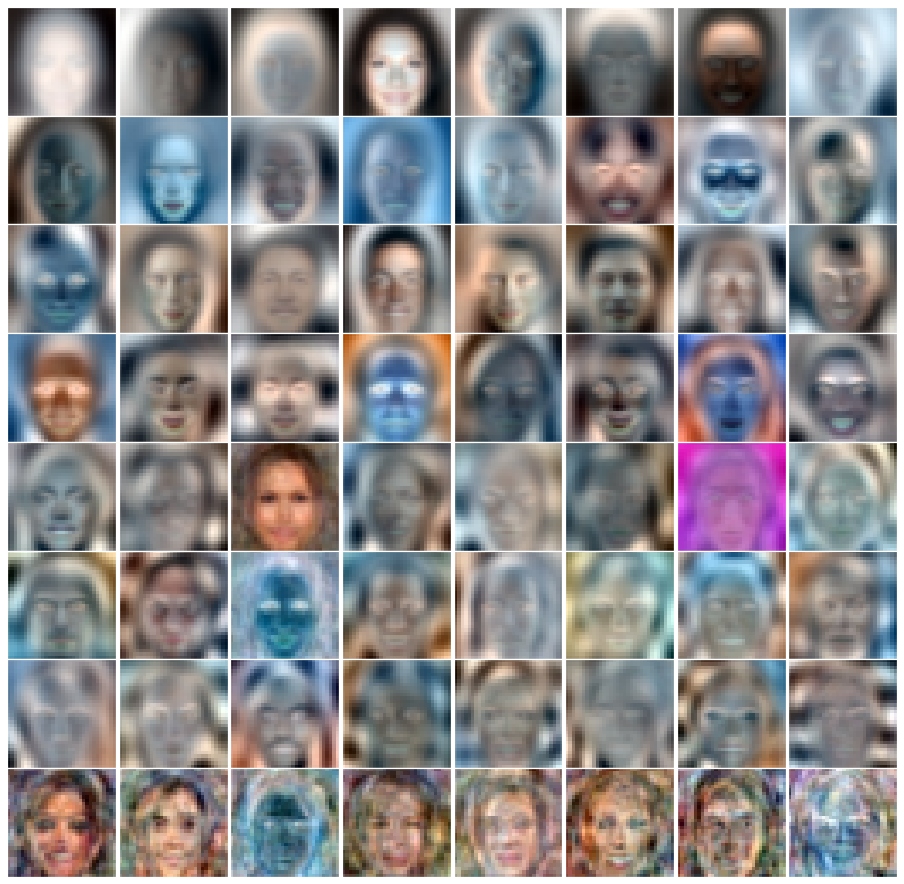

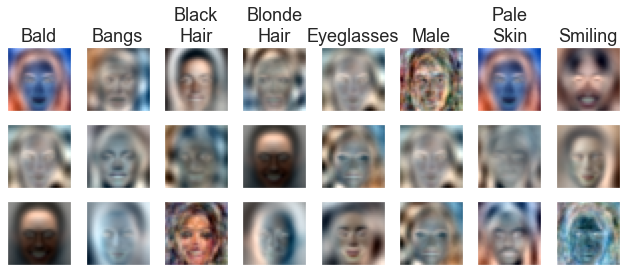

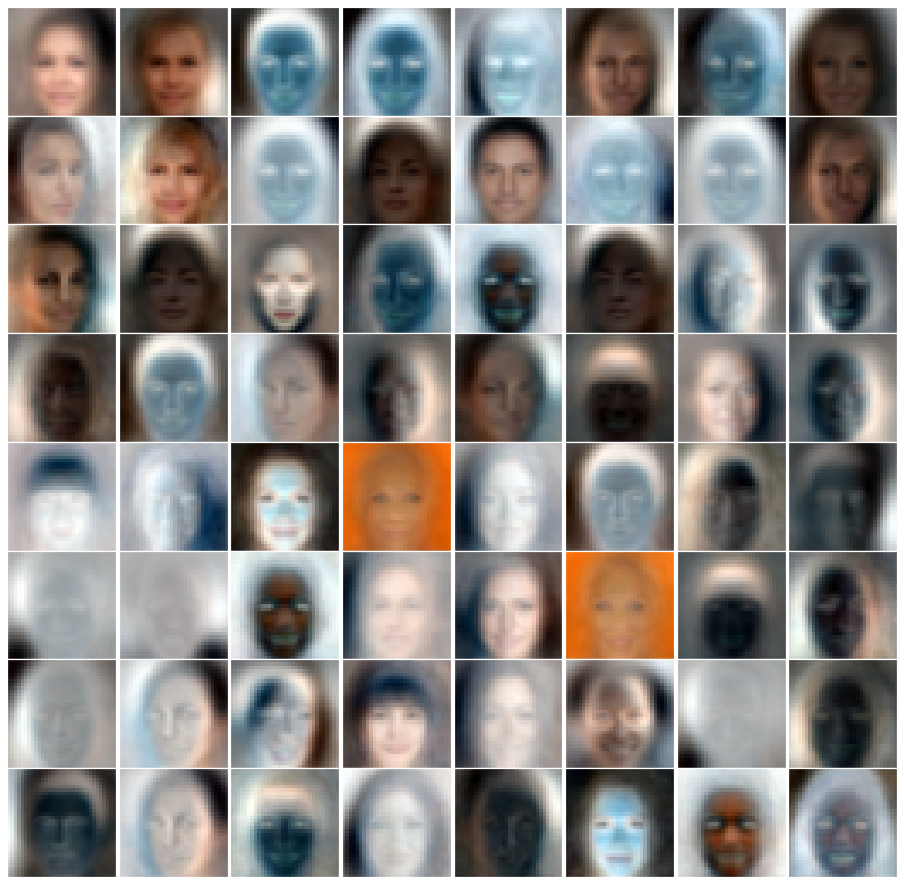

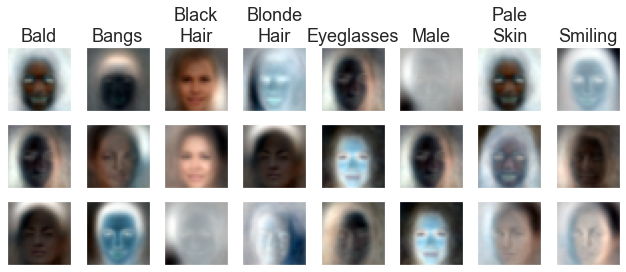

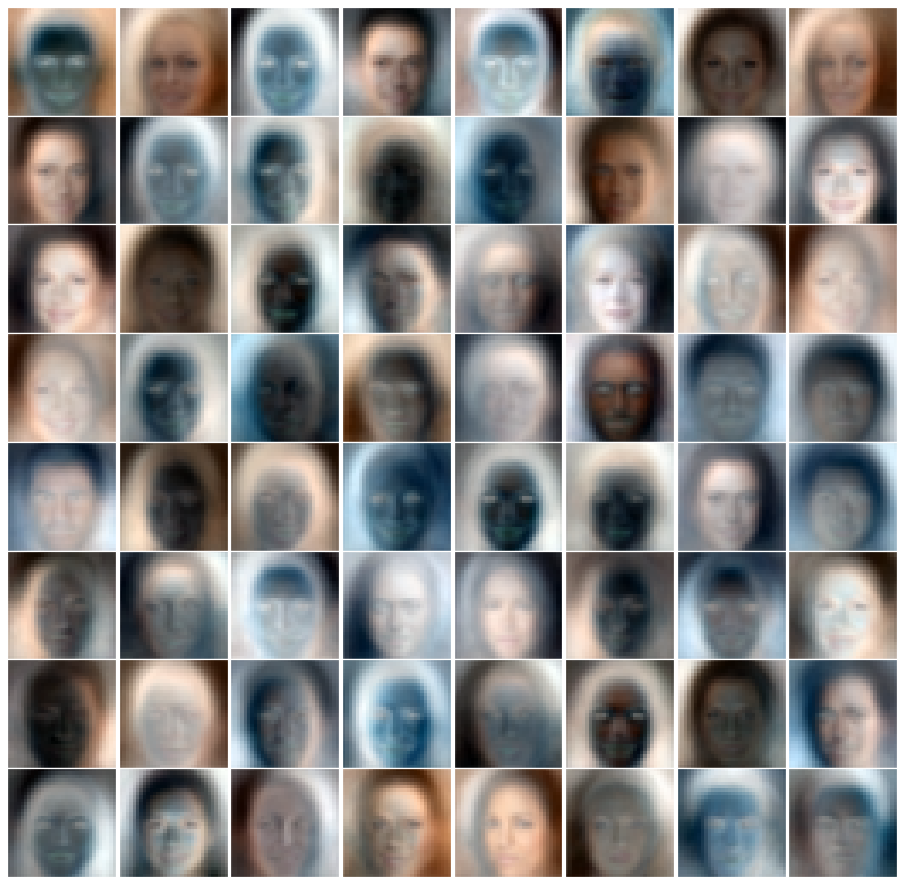

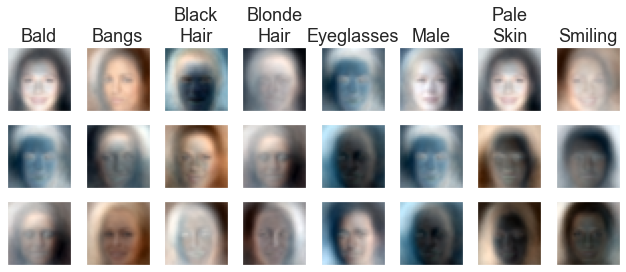

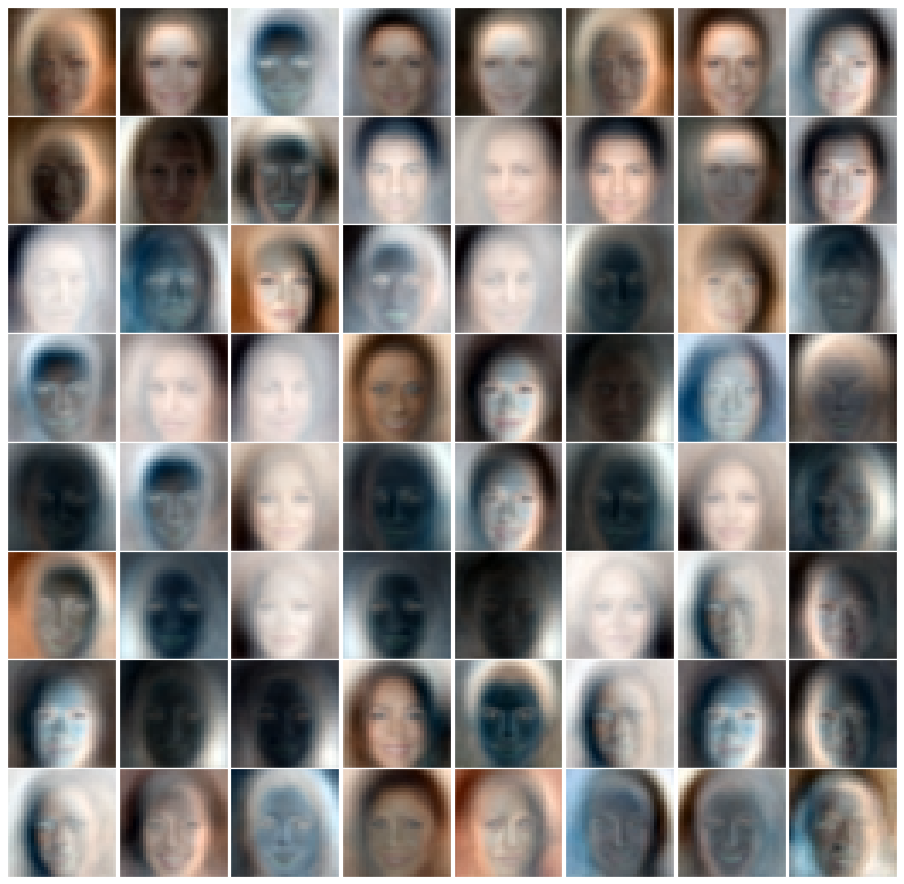

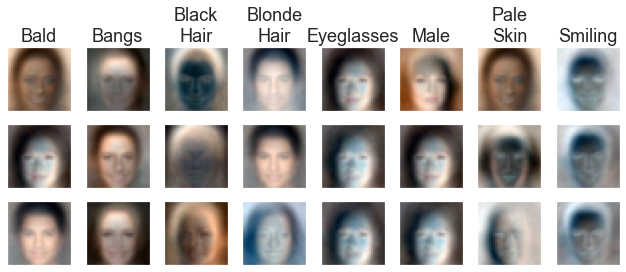

In [6]:
for idx, run_name in enumerate(file_labels):
    C_sr = (y_hat.T @ x_samp_dict[run_name][0]) / len(y_hat)
    C_rr = (x_samp_dict[run_name][0].T @ x_samp_dict[run_name][0]) / len(y_hat)

    A = C_sr @ np.linalg.pinv(C_rr)
    
    A_mag = np.argsort(-1*torch.linalg.norm(A, axis=0))
    dict_indices = np.arange(64)
    for i in range(8):
        select_indices = (z//8)*i + np.arange(8)
        dict_indices[i*8:(i+1)*8] = A_mag[select_indices]
    fig = plt.figure(figsize=(16, 16))

    for idx, i in enumerate(dict_indices):
        plt.subplot(8, 8, idx + 1)
        current_dict = A[:, i] / torch.linalg.norm(A[:, i])
        dict_element = current_dict.reshape(3, 32, 32).permute(1, 2, 0)

        #print(dict_element.max())
        dict_element = (dict_element - dict_element.min())
        dict_element = (dict_element / dict_element.max())
        plt.imshow(dict_element)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    #fig.suptitle(f"Recovered Dictionary for {run_name}", fontsize=18)
    plt.subplots_adjust(wspace=0, hspace=0)

    label_list = np.array(list(attribute_labels.keys()))
    attribute_idx = [i for i in range(len(label_list)) if attribute_labels[label_list[i]]]  
    fig, axs = plt.subplots(3, len(attribute_idx), figsize=(11,4))
    for i in range(len(attribute_idx)):
        top_feature = np.argsort(-1*correlation_dict[train_run][:, attribute_idx[i]])

        for j in range(3):
            current_dict = A[:, top_feature[j]] / torch.linalg.norm(A[:, top_feature[j]])
            dict_element = current_dict.reshape(3, 32, 32).permute(1, 2, 0)
            dict_element = (dict_element - dict_element.min())
            dict_element = (dict_element / dict_element.max())
            
            axs[j,i].imshow(dict_element)

        axs[0,i].set_title(label_list[attribute_idx[i]].replace(" ", "\n"), fontsize=18)

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

torch.Size([50, 3, 64, 64])


/tmp/ipykernel_1074492/3359461254.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_decode = torch.tensor(x_decode).to(default_device)


[]

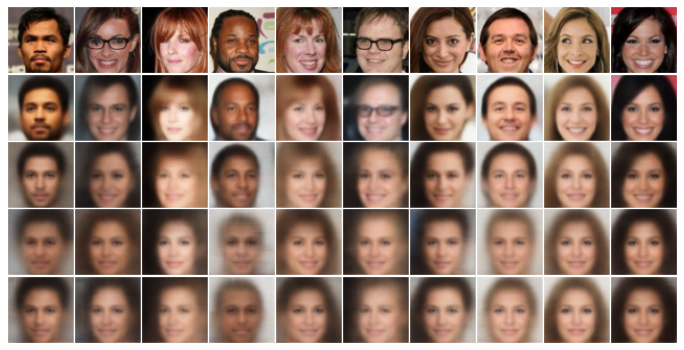

In [7]:
num_images = 10 
batch_iter = 18
fig, ax = plt.subplots(nrows=5, ncols=num_images, figsize=(12, 6.2))

loader_iter = iter(test_loader)
for j in range(batch_iter):
    _ = next(loader_iter)
x = next(loader_iter)[0]
print(x.shape)
for i in range(num_images):
    ax[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy())

for file_idx, train_run in enumerate(file_list):
    with open(train_run + 'config.json') as json_data:
        config_data = json.load(json_data)
    train_args = SimpleNamespace(**config_data['train'])
    solver_args = SimpleNamespace(**config_data['solver'])
    decoder = ConvDecoder(train_args.dict_size, 3).to(default_device)
    model_state = torch.load(train_run + f"modelstate_epoch200.pt", map_location=default_device)
    decoder.load_state_dict(model_state['decoder'])
    x_decode = x_samp_dict[file_labels[file_idx]][0][50*(batch_iter):50*(batch_iter)+num_images]
    x_decode = torch.tensor(x_decode).to(default_device)

    for im_idx in range(num_images):
        x_hat = decoder(x_decode)
        ax[file_idx+1, im_idx].imshow(x_hat[im_idx].permute(1, 2, 0).detach().cpu().numpy())
plt.subplots_adjust(wspace=0, hspace=0)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
